## Data Preparation

### 1.1 Importing necessary Libriaries

In [43]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc

### 1.2 Loading Data

In [2]:
# loading data
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

#### Checking data structure, missing values and duplicates

In [3]:
# Check structure and missing values
for name, df in zip(['Contract', 'Personal', 'Internet', 'Phone'],
                    [df_contract, df_personal, df_internet, df_phone]):
    print(f"--- {name} Dataset ---")
    print(df.info())
    print(df.isna().sum(), "\n")

--- Contract Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64 

--- Personal Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column       

In [4]:
# Check for duplicate rows in each dataset
for name, df in zip(['Contract', 'Personal', 'Internet', 'Phone'],
                    [df_contract, df_personal, df_internet, df_phone]):
    duplicate_count = df.duplicated().sum()
    print(f"--- {name} Dataset ---")
    print(f"Total rows: {len(df)}")
    print(f"Duplicate rows: {duplicate_count}\n")

--- Contract Dataset ---
Total rows: 7043
Duplicate rows: 0

--- Personal Dataset ---
Total rows: 7043
Duplicate rows: 0

--- Internet Dataset ---
Total rows: 5517
Duplicate rows: 0

--- Phone Dataset ---
Total rows: 6361
Duplicate rows: 0



### 1.3 Merge the Datasets

In [5]:
# Step-by-step merge on 'customerID'
df_merged = df_contract.merge(df_personal, on='customerID', how='left')
df_merged = df_merged.merge(df_internet, on='customerID', how='left')
df_merged = df_merged.merge(df_phone, on='customerID', how='left')

# Display basic info of the merged dataset
print("Merged dataset:")
print(df_merged.info())

Merged dataset:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non

 ### 1.4 Create the Target Feature (churn)

In [6]:
# Create 'churn' target column
df_merged['churn'] = (df_merged['EndDate'] != 'No').astype(int)
df_merged.drop(columns='EndDate', inplace=True)

In [7]:
print(df_merged['churn'].value_counts(normalize=True))

0    0.73463
1    0.26537
Name: churn, dtype: float64


### 1.5 Handle Missing Values

In [8]:
# Find and display missing values
missing = df_merged.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values:\n")
print(missing)

Columns with missing values:

InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


 #### Interpretation of Missing Values

- Internet-related columns (1,526 missing):
These 1,526 customers likely don’t subscribe to Internet service at all, which is why all these columns are missing:

  -InternetService

  -OnlineSecurity

  -OnlineBackup

  -DeviceProtection

  -TechSupport

  -StreamingTV

  -StreamingMovies

**So we can safely fill these with 'No' to indicate that they are not subscribed.**

- Phone-related column (MultipleLines, 682 missing):
This usually means the customer doesn’t have phone service, **so MultipleLines is not applicable  also fill with 'No'.**




#### Handling missing values for both internet services and Phone-related column

In [9]:
# List of internet-related columns to fill with 'No'
internet_cols_to_fill = [
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# Fill missing internet-related values with 'No'
df_merged[internet_cols_to_fill] = df_merged[internet_cols_to_fill].fillna('No')

In [10]:
# Fill missing value in 'MultipleLines' with 'No'
df_merged['MultipleLines'] = df_merged['MultipleLines'].fillna('No')

In [11]:
# Make sure all missing values are gone
print("Remaining missing values:", df_merged.isna().sum().sum())

Remaining missing values: 0


#### There are no missing values in our dataframe.

## 2 Exploratory Data Analysis (EDA)

The goal of EDA is to:

- Understand the distribution of the target variable (churn)

- Explore relationships between features and churn

- Identify important trends or patterns

### 2.1 Churn Distribution

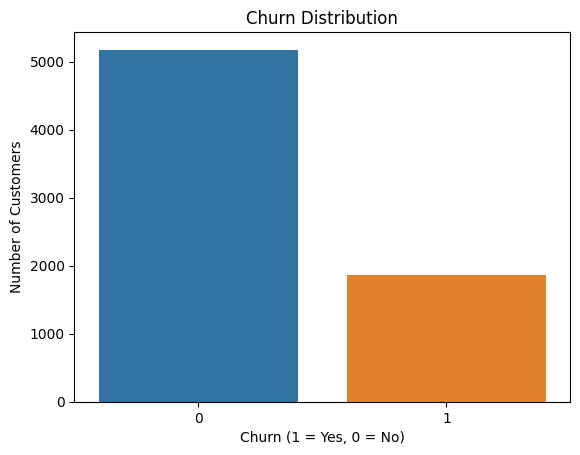

0    73.46%
1    26.54%
Name: churn, dtype: object


In [12]:
# Churn distribution
sns.countplot(data=df_merged, x='churn')
plt.title('Churn Distribution')
plt.xlabel('Churn (1 = Yes, 0 = No)')
plt.ylabel('Number of Customers')
plt.show()

# percent display
print(df_merged['churn'].value_counts(normalize=True).map("{:.2%}".format))

### 2.2 Numerical Features vs. Churn

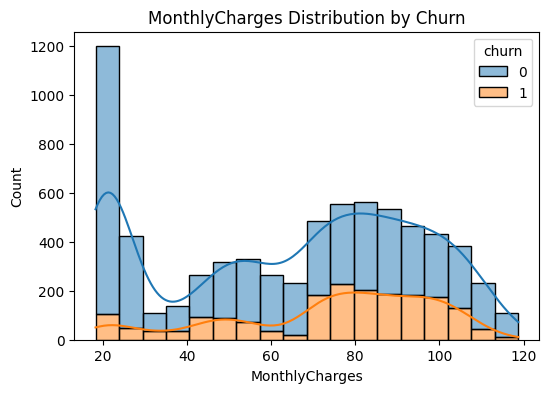

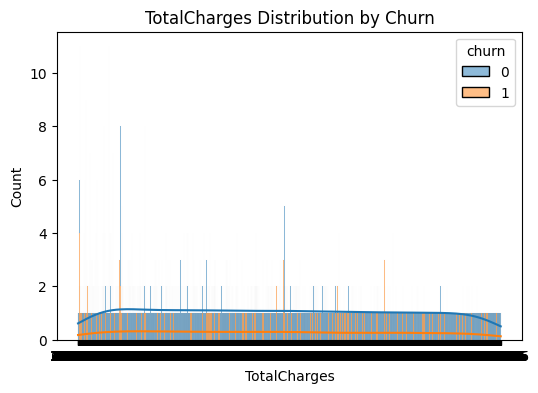

In [13]:
num_features = ['MonthlyCharges', 'TotalCharges']

for col in num_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df_merged, x=col, hue='churn', kde=True, multiple='stack')
    plt.title(f'{col} Distribution by Churn')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

### 2.3 Categorical Features vs. Churn

In [14]:
cat_features = [
    'Type',               
    'PaperlessBilling',
    'PaymentMethod',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies',
    'MultipleLines',
    'gender',
    'SeniorCitizen',
    'Partner',
    'Dependents'
]

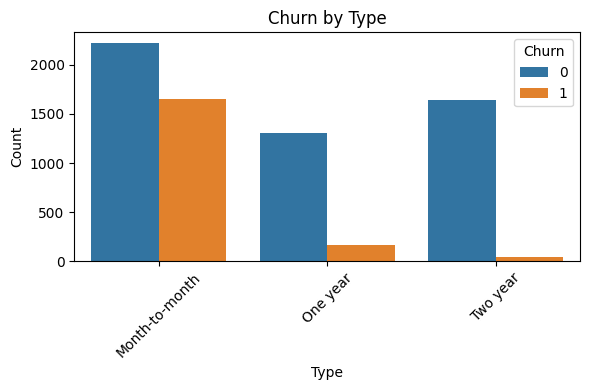

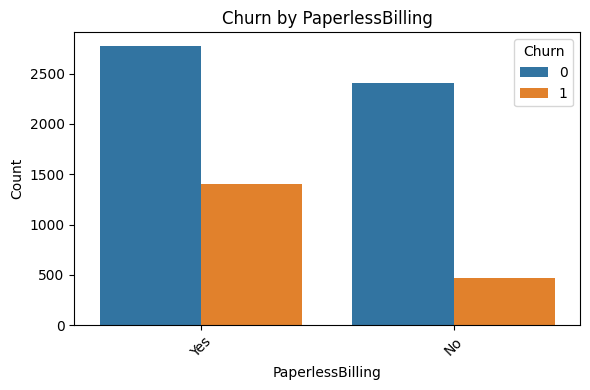

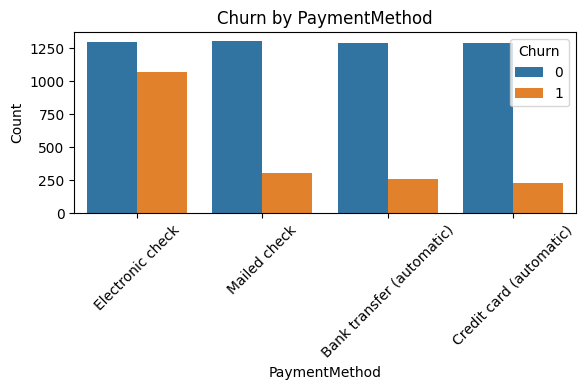

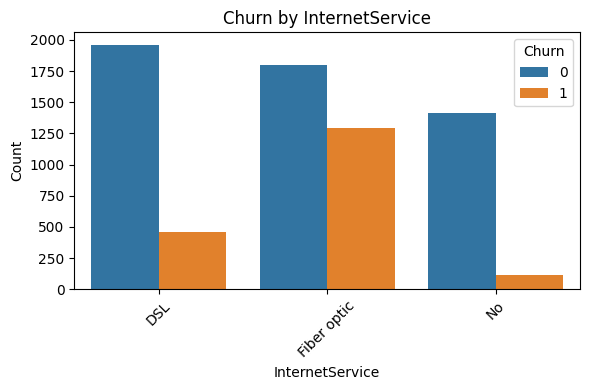

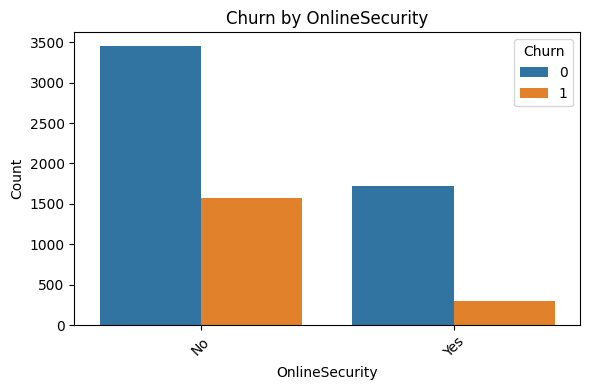

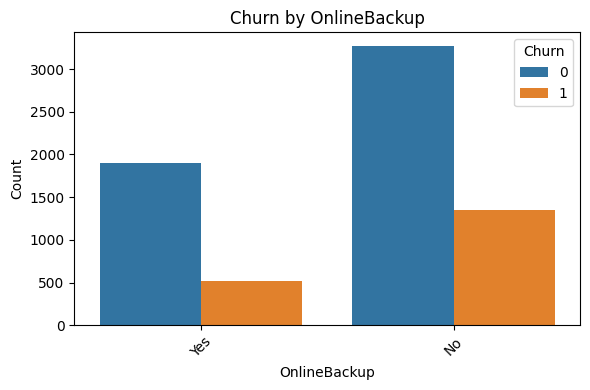

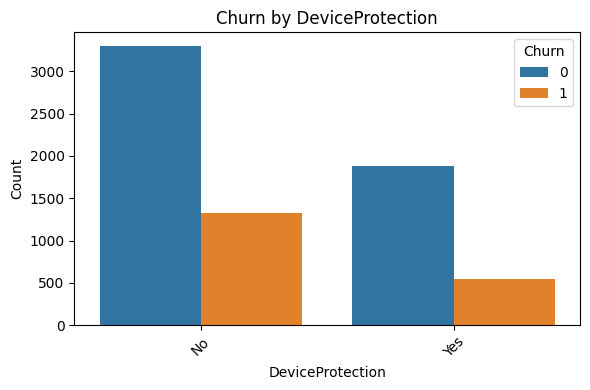

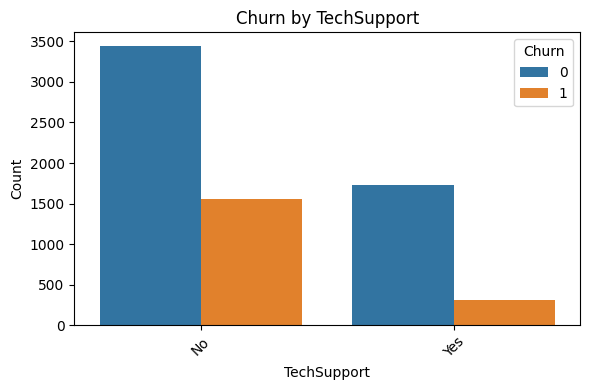

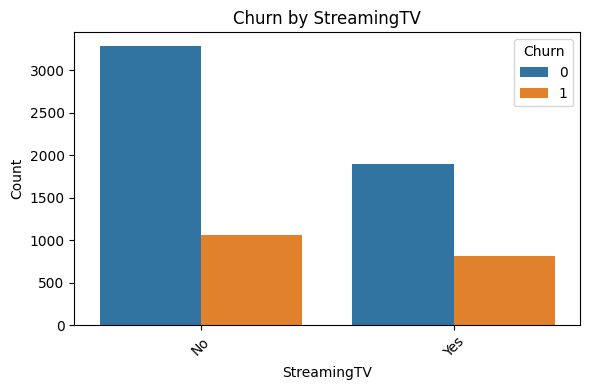

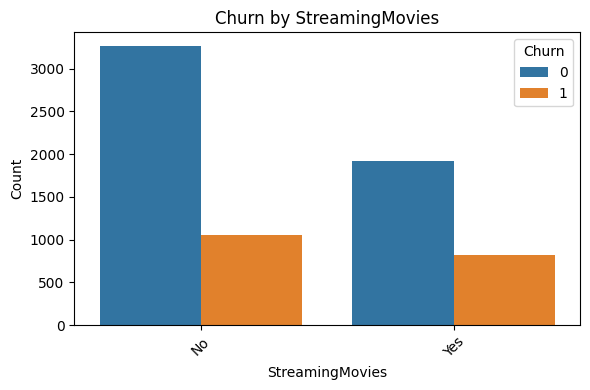

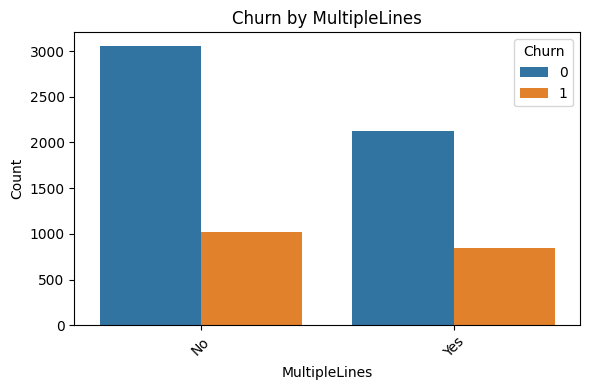

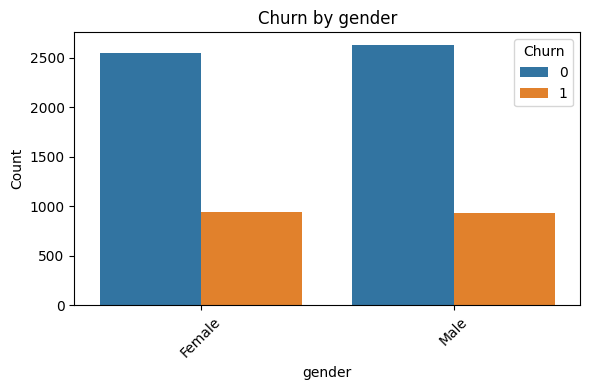

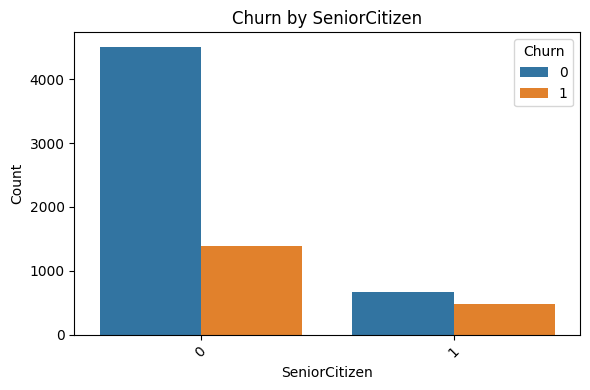

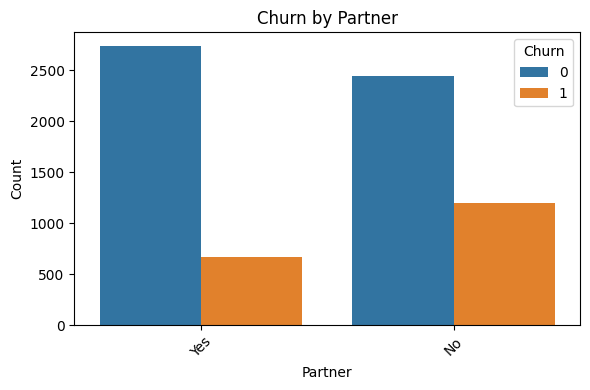

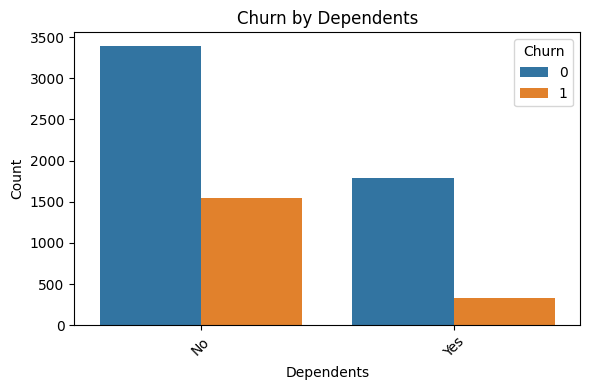

In [15]:
for col in cat_features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df_merged, x=col, hue='churn')
    plt.title(f'Churn by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Churn')
    plt.tight_layout()
    plt.show()


### 2.4: Explore Numerical Features and Their Relationship with Churn

#####  Convert 'TotalCharges' to Numeric 

In [16]:
# Convert 'TotalCharges' to numeric (coerce errors to NaN)
df_merged['TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'], errors='coerce')

In [17]:
print(df_merged['TotalCharges'].isna().sum())

11


In [18]:
# Option: Drop rows with missing TotalCharges
df_merged = df_merged.dropna(subset=['TotalCharges'])

##### Visualize Distributions by Churn

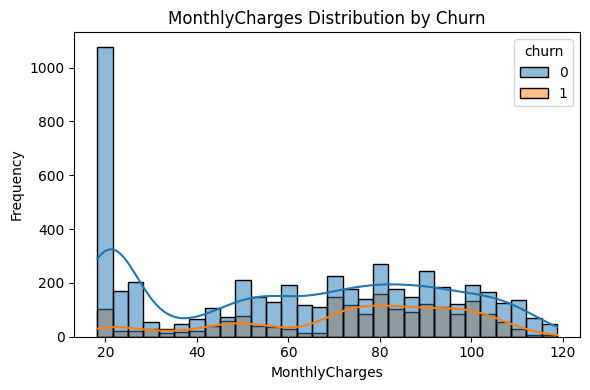

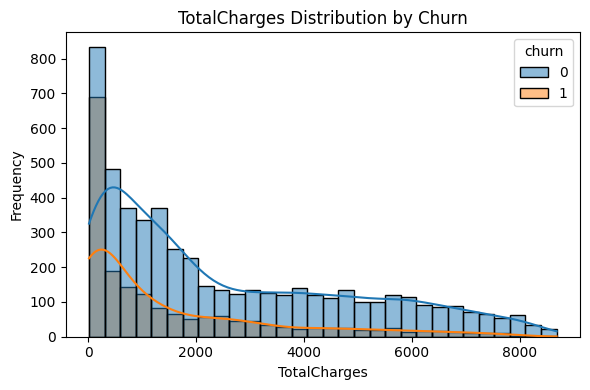

In [19]:
num_features = ['MonthlyCharges', 'TotalCharges']

for col in num_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df_merged, x=col, hue='churn', kde=True, bins=30)
    plt.title(f'{col} Distribution by Churn')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

##### Boxplots for Visual Comparison

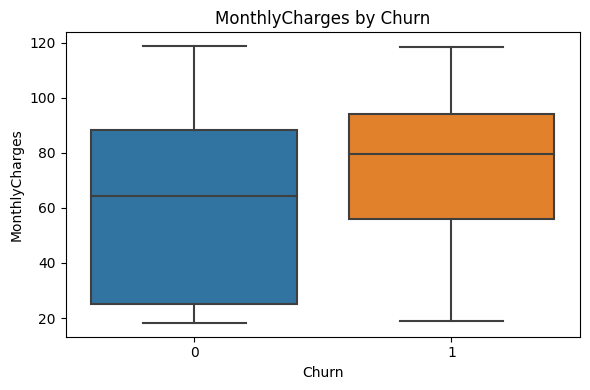

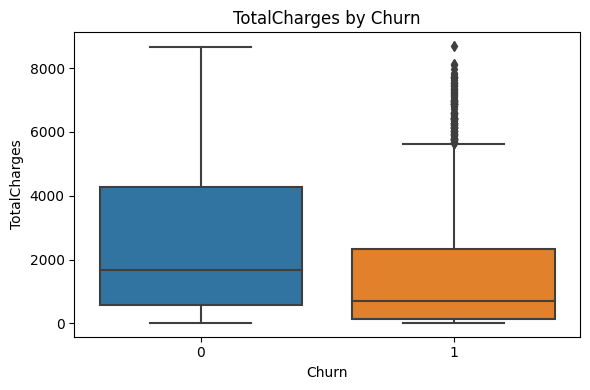

In [20]:
for col in num_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_merged, x='churn', y=col)
    plt.title(f'{col} by Churn')
    plt.xlabel('Churn')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

##  3. Data Preprocessing for Modeling

### 3.1 Convert TotalCharges to Numeric

In [21]:
# Convert TotalCharges to numeric
df_merged.loc[:, 'TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'], errors='coerce')
# Check if conversion introduced any NaNs
print(df_merged['TotalCharges'].isna().sum())

0


### 3.2 Encode Categorical Variables

##### Binary categorical features

In [22]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'MultipleLines',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies']

# Convert to 0 and 1

for col in binary_cols:
    df_merged.loc[:, col] = df_merged[col].replace({
        'Yes': 1, 'No': 0,
        'Male': 1, 'Female': 0,
        'No internet service': 0,
        'No phone service': 0
    })

##### Nominal categorical features

In [23]:
nominal_cols = ['InternetService', 'PaymentMethod', 'Type']

df_merged = pd.get_dummies(df_merged, columns=nominal_cols, drop_first=True)

### 3.3 Feature Scaling

In [24]:
# Select numeric columns to scale
num_cols = ['MonthlyCharges', 'TotalCharges']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
df_merged[num_cols] = scaler.fit_transform(df_merged[num_cols])


### 3.4 One-Hot Encode Remaining Categorical Features

##### Identify remaining categorical columns

In [25]:
df_merged.select_dtypes(include='object').columns

Index(['customerID', 'BeginDate'], dtype='object')

##### Perform One-Hot Encoding

In [26]:
# Check which of the three columns are still in the dataframe
cols_to_drop = [col for col in ['customerID', 'BeginDate', 'EndDate'] if col in df_merged.columns]

# Drop only the ones that exist
df_model = df_merged.drop(columns=cols_to_drop)

# Now apply one-hot encoding
df_model = pd.get_dummies(df_model, drop_first=True)

## 4. Models

### 4.1 Splitting the data and training models

In [27]:
# Target column where 1 = churned, 0 = stayed
target = 'churn'

 ### 4.2 Split the data

In [28]:
# Features and target
X = df_model.drop(columns=['churn'])  # assuming you have a 'churn' target
y = df_model['churn']

# Step 1: First split — reserve 10% as final test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=1234
)

# Step 2: Split the remaining 90% into training and validation sets 
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=1234
)

##### Handle Class Imbalance with Upsampling

In [29]:
# Combine X_train and y_train
y_train.name = 'Churn'
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority class
majority = train_data[train_data['Churn'] == 0]
minority = train_data[train_data['Churn'] == 1]

# Upsample minority class
minority_upsampled = resample(minority,
                               replace=True,     # sample with replacement
                               n_samples=len(majority),  # match number in majority
                               random_state=1234)

# Combine back
train_upsampled = pd.concat([majority, minority_upsampled])

# New training sets
X_train_up = train_upsampled.drop('Churn', axis=1)
y_train_up = train_upsampled['Churn']

### 4.3 Train a baseline model Logistic Regression

In [30]:
# Train logistic regression
log_model = LogisticRegression(max_iter=1000, random_state=1234)
log_model.fit(X_train_up, y_train_up)

# Predict on validation set
y_pred_log = log_model.predict(X_valid)
y_proba_log = log_model.predict_proba(X_valid)[:, 1]

# Evaluate
print("Logistic Regression Evaluation")
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred_log))
print("Classification Report:\n", classification_report(y_valid, y_pred_log))
print("AUC-ROC Score:", roc_auc_score(y_valid, y_proba_log))

print("AUC-ROC:", roc_auc_score(y_valid, y_proba_log))
print("Accuracy:", accuracy_score(y_valid, y_pred_log))
print("F1 Score:", f1_score(y_valid, y_pred_log))
print("Precision:", precision_score(y_valid, y_pred_log))
print("Recall:", recall_score(y_valid, y_pred_log))

Logistic Regression Evaluation
Confusion Matrix:
 [[657 272]
 [ 66 271]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80       929
           1       0.50      0.80      0.62       337

    accuracy                           0.73      1266
   macro avg       0.70      0.76      0.71      1266
weighted avg       0.80      0.73      0.75      1266

AUC-ROC Score: 0.827909145790279
AUC-ROC: 0.827909145790279
Accuracy: 0.7330173775671406
F1 Score: 0.615909090909091
Precision: 0.4990791896869245
Recall: 0.8041543026706232


#####  Hyperparameter Tuning with GridSearchCV on Logistic Regression Model

In [31]:
# Define the logistic model
log_model = LogisticRegression(solver='liblinear', random_state=1234)

# Set hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization strength
    'penalty': ['l1', 'l2']         # L1 = Lasso, L2 = Ridge
}

# Grid search with 5-fold cross-validation
grid = GridSearchCV(log_model, param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train_up, y_train_up)

# Best model
best_log_model = grid.best_estimator_

# Predict and get probabilities
y_pred = best_log_model.predict(X_valid)
y_proba = best_log_model.predict_proba(X_valid)[:, 1]


# Print evaluation
print("Best Parameters:", grid.best_params_)
print("ROC-AUC Score:", roc_auc_score(y_valid, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_pred))


Best Parameters: {'C': 1, 'penalty': 'l2'}
ROC-AUC Score: 0.8278005449208332
Confusion Matrix:
 [[657 272]
 [ 66 271]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.71      0.80       929
           1       0.50      0.80      0.62       337

    accuracy                           0.73      1266
   macro avg       0.70      0.76      0.71      1266
weighted avg       0.80      0.73      0.75      1266



**Implication of Result**
From the confusion matrix, you will find that:
- True Negatives (TN): 751 – Correctly predicted not churn.

- False Positives (FP): 282 – Predicted churn when it didn’t happen.

- False Negatives (FN): 93 – Missed churned customers.

- True Positives (TP): 281 – Correctly predicted churn.

The model is catching most churners (low FN), but at the cost of some FP and it is very excellent at distinguishing churners at 82% approximately.

### Random Forest Classifier

In [32]:

# Re-train Random Forest model on upsampled data
rf_model = RandomForestClassifier(random_state=1234)
rf_model.fit(X_train_up, y_train_up)

# Predict on validation set
y_pred_rf = rf_model.predict(X_valid)
y_proba_rf = rf_model.predict_proba(X_valid)[:, 1]

# Evaluate
roc_auc_rf = roc_auc_score(y_valid, y_proba_rf)
conf_matrix_rf = confusion_matrix(y_valid, y_pred_rf)
class_report_rf = classification_report(y_valid, y_pred_rf, output_dict=True)




# Print evaluation
print("ROC-AUC Score:", roc_auc_rf)
print("Confusion Matrix:\n", conf_matrix_rf)
print("\nClassification Report:\n", classification_report(y_valid, y_pred_rf))


ROC-AUC Score: 0.7962008860553289
Confusion Matrix:
 [[783 146]
 [157 180]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84       929
           1       0.55      0.53      0.54       337

    accuracy                           0.76      1266
   macro avg       0.69      0.69      0.69      1266
weighted avg       0.76      0.76      0.76      1266



##### Hyperparameter Tuning for RandomForestClassifier

In [33]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']  
}

# Instantiate the RandomForestClassifier
rf = RandomForestClassifier(random_state=1234)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on the upsampled training data
grid_search.fit(X_train_up, y_train_up)

# Best model
best_rf_model = grid_search.best_estimator_

# Predict on validation set
y_pred_rf_tuned = best_rf_model.predict(X_valid)
y_proba_rf_tuned = best_rf_model.predict_proba(X_valid)[:, 1]

# Evaluate performance
roc_auc = roc_auc_score(y_valid, y_proba_rf_tuned)
conf_matrix = confusion_matrix(y_valid, y_pred_rf_tuned)
class_report = classification_report(y_valid, y_pred_rf_tuned)

# Print results
print("Best Parameters:", grid_search.best_params_)
print("ROC-AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
ROC-AUC Score: 0.7993279522667237
Confusion Matrix:
 [[783 146]
 [156 181]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84       929
           1       0.55      0.54      0.55       337

    accuracy                           0.76      1266
   macro avg       0.69      0.69      0.69      1266
weighted avg       0.76      0.76      0.76      1266



### XGBoost Classifier 

In [34]:
# Initialize XGBoost Classifier 
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train on upsampled data
xgb_model.fit(X_train_up, y_train_up)

# Predict on validation data
y_pred_xgb = xgb_model.predict(X_valid)
y_proba_xgb = xgb_model.predict_proba(X_valid)[:, 1]

# Evaluate performance
roc_auc = roc_auc_score(y_valid, y_proba_xgb)
conf_matrix = confusion_matrix(y_valid, y_pred_xgb)
class_report = classification_report(y_valid, y_pred_xgb)

# Display results
print("ROC-AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

ROC-AUC Score: 0.7949599614147499
Confusion Matrix:
 [[750 179]
 [131 206]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.81      0.83       929
           1       0.54      0.61      0.57       337

    accuracy                           0.76      1266
   macro avg       0.69      0.71      0.70      1266
weighted avg       0.77      0.76      0.76      1266



##### Hyperparameter Tuning for XGBoosting

In [35]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the parameter distributions for random search
param_dist = {
    'n_estimators': randint(50, 200),           # number of trees
    'max_depth': randint(3, 7),                 # tree depth
    'learning_rate': uniform(0.05, 0.2),        # shrinkage
    'subsample': uniform(0.8, 0.2),             # row sampling
    'colsample_bytree': uniform(0.8, 0.2)       # feature sampling
}

# Randomized search
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=10,                  # Only test 10 random combinations
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,                  # Use all CPU cores
    verbose=1,
    random_state=42
)

# Fit on upsampled training data
random_search.fit(X_train_up, y_train_up)

# Best model
best_xgb = random_search.best_estimator_

# Predict on validation set
y_pred_xgb_tuned = best_xgb.predict(X_valid)
y_proba_xgb_tuned = best_xgb.predict_proba(X_valid)[:, 1]

# Evaluate performance
print("Best Parameters:", random_search.best_params_)
print("AUC-ROC:", roc_auc_score(y_valid, y_proba_xgb_tuned))
print("Accuracy:", accuracy_score(y_valid, y_pred_xgb_tuned))
print("F1 Score:", f1_score(y_valid, y_pred_xgb_tuned))
print("Precision:", precision_score(y_valid, y_pred_xgb_tuned))
print("Recall:", recall_score(y_valid, y_pred_xgb_tuned))
print(confusion_matrix(y_valid, y_pred_xgb_tuned))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'colsample_bytree': 0.8749080237694725, 'learning_rate': 0.24014286128198326, 'max_depth': 5, 'n_estimators': 121, 'subsample': 0.9197316968394074}
AUC-ROC: 0.8092250050307757
Accuracy: 0.7432859399684044
F1 Score: 0.5660881174899867
Precision: 0.5145631067961165
Recall: 0.629080118694362
[[729 200]
 [125 212]]


### CatBoost Classifier Model

In [36]:
# Instantiate the model with basic settings
cat_model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    depth=6,
    verbose=0,
    random_state=42
)

# Fit the model on the upsampled training data
cat_model.fit(X_train_up, y_train_up)

# Predict on validation set
y_pred_cat = cat_model.predict(X_valid)
y_proba_cat = cat_model.predict_proba(X_valid)[:, 1]

# Print evaluation metrics
print("AUC-ROC:", roc_auc_score(y_valid, y_proba_cat))
print("Accuracy:", accuracy_score(y_valid, y_pred_cat))
print("\nConfusion Matrix:\n", confusion_matrix(y_valid, y_pred_cat))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_cat))


AUC-ROC: 0.8168222746771521
Accuracy: 0.7488151658767772

Confusion Matrix:
 [[710 219]
 [ 99 238]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.82       929
           1       0.52      0.71      0.60       337

    accuracy                           0.75      1266
   macro avg       0.70      0.74      0.71      1266
weighted avg       0.78      0.75      0.76      1266



##### Hyperparameter Tuning for CatBoost Model

In [37]:
# Define the model
cat_model = CatBoostClassifier(
    verbose=0,
    random_state=42
)

# Define a small hyperparameter grid
param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Setup GridSearchCV
grid_search_cat = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit on upsampled training data
grid_search_cat.fit(X_train_up, y_train_up)

# Best parameters
print("Best Parameters:", grid_search_cat.best_params_)

# Best estimator
best_cat = grid_search_cat.best_estimator_

# Predict and evaluate
y_pred_best_cat = best_cat.predict(X_valid)
y_proba_best_cat = best_cat.predict_proba(X_valid)[:, 1]


print("AUC-ROC:", roc_auc_score(y_valid, y_proba_best_cat))
print("Accuracy:", accuracy_score(y_valid, y_pred_best_cat))
print("\nConfusion Matrix:\n", confusion_matrix(y_valid, y_pred_best_cat))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_best_cat))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'depth': 8, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
AUC-ROC: 0.810715072842436
Accuracy: 0.7567140600315956

Confusion Matrix:
 [[741 188]
 [120 217]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.80      0.83       929
           1       0.54      0.64      0.58       337

    accuracy                           0.76      1266
   macro avg       0.70      0.72      0.71      1266
weighted avg       0.77      0.76      0.76      1266



### LightGBM 

In [38]:
# Instantiate the model
lgbm_model = LGBMClassifier(random_state=1234)

# Fit to upsampled training data
lgbm_model.fit(X_train_up, y_train_up)

# Predict on validation set
y_pred_lgbm = lgbm_model.predict(X_valid)
y_proba_lgbm = lgbm_model.predict_proba(X_valid)[:, 1]

# Evaluate the model


print("AUC-ROC:", roc_auc_score(y_valid, y_proba_lgbm))
print("Accuracy:", accuracy_score(y_valid, y_pred_lgbm))
print("\nConfusion Matrix:\n", confusion_matrix(y_valid, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_lgbm))




AUC-ROC: 0.8189128414139834
Accuracy: 0.7535545023696683

Confusion Matrix:
 [[711 218]
 [ 94 243]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82       929
           1       0.53      0.72      0.61       337

    accuracy                           0.75      1266
   macro avg       0.71      0.74      0.71      1266
weighted avg       0.79      0.75      0.76      1266



##### Hyperparameter Tuning for LightGBM

In [39]:
# Define a simple parameter grid to keep tuning fast
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

# Initialize model
lgbm = LGBMClassifier(random_state=123)

# Stratified k-fold to maintain class balance in folds
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Fit on the upsampled data
grid_search.fit(X_train_up, y_train_up)

# Best model
best_lgbm = grid_search.best_estimator_

# Predict and evaluate
y_pred_best = best_lgbm.predict(X_valid)
y_proba_best = best_lgbm.predict_proba(X_valid)[:, 1]


print("AUC-ROC:", roc_auc_score(y_valid, y_proba_best))
print("Accuracy:", accuracy_score(y_valid, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_valid, y_pred_best))
print("\nClassification Report:\n", classification_report(y_valid, y_pred_best))

Fitting 3 folds for each of 24 candidates, totalling 72 fits
AUC-ROC: 0.8187515371814242
Accuracy: 0.7472353870458136

Confusion Matrix:
 [[704 225]
 [ 95 242]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81       929
           1       0.52      0.72      0.60       337

    accuracy                           0.75      1266
   macro avg       0.70      0.74      0.71      1266
weighted avg       0.78      0.75      0.76      1266



In [40]:
# Create a comparison of your models
model_comparison = {
    'Model': ['Logistic Regression', 'Logistic Regression(Tuned)', 'Random Forest', 'Random Forest(Tuned)','XGBoost Classifier','XGBoost Classifier(tuned)', 'CatBoost', 'CatBoost(tuned)', 'LightGBM', 'LightGBM(Tuned)'],
    'AUC-ROC': [roc_auc_score(y_valid, y_proba_log), roc_auc_score(y_valid, y_proba), roc_auc_score(y_valid, y_proba_rf), roc_auc_score(y_valid, y_proba_rf_tuned), roc_auc_score(y_valid, y_proba_xgb), roc_auc_score(y_valid, y_proba_xgb_tuned), roc_auc_score(y_valid, y_proba_cat), roc_auc_score(y_valid, y_proba_best_cat), roc_auc_score(y_valid, y_proba_lgbm), roc_auc_score(y_valid, y_proba_best)],
    'Accuracy': [accuracy_score(y_valid, y_pred_log), accuracy_score(y_valid, y_pred), accuracy_score(y_valid, y_pred_rf), accuracy_score(y_valid, y_pred_rf_tuned), accuracy_score(y_valid, y_pred_xgb), accuracy_score(y_valid, y_pred_xgb_tuned), accuracy_score(y_valid, y_pred_cat), accuracy_score(y_valid, y_pred_best_cat), accuracy_score(y_valid, y_pred_lgbm), accuracy_score(y_valid, y_pred_best)],
    'F1 Score': [f1_score(y_valid, y_pred_log), f1_score(y_valid, y_pred), f1_score(y_valid, y_pred_rf), f1_score(y_valid, y_pred_rf_tuned), f1_score(y_valid, y_pred_xgb), f1_score(y_valid, y_pred_xgb_tuned), f1_score(y_valid, y_pred_cat), f1_score(y_valid, y_pred_best_cat), f1_score(y_valid, y_pred_lgbm), f1_score(y_valid, y_pred_best)],
    'Precision': [precision_score(y_valid, y_pred_log), precision_score(y_valid, y_pred), precision_score(y_valid, y_pred_rf), precision_score(y_valid, y_pred_rf_tuned), precision_score(y_valid, y_pred_xgb), precision_score(y_valid, y_pred_xgb_tuned), precision_score(y_valid, y_pred_cat), precision_score(y_valid, y_pred_best_cat), precision_score(y_valid, y_pred_lgbm), precision_score(y_valid, y_pred_best)],
    'Recall': [recall_score(y_valid, y_pred_log), recall_score(y_valid, y_pred), recall_score(y_valid, y_pred_rf), recall_score(y_valid, y_pred_rf_tuned), recall_score(y_valid, y_pred_xgb), recall_score(y_valid, y_pred_xgb_tuned), recall_score(y_valid, y_pred_cat), recall_score(y_valid, y_pred_best_cat), recall_score(y_valid, y_pred_lgbm), recall_score(y_valid, y_pred_best)]
}

comparison_df = pd.DataFrame(model_comparison)
print(comparison_df)

                        Model   AUC-ROC  Accuracy  F1 Score  Precision  \
0         Logistic Regression  0.827909  0.733017  0.615909   0.499079   
1  Logistic Regression(Tuned)  0.827801  0.733017  0.615909   0.499079   
2               Random Forest  0.796201  0.760664  0.542986   0.552147   
3        Random Forest(Tuned)  0.799328  0.761453  0.545181   0.553517   
4          XGBoost Classifier  0.794960  0.755134  0.570637   0.535065   
5   XGBoost Classifier(tuned)  0.809225  0.743286  0.566088   0.514563   
6                    CatBoost  0.816822  0.748815  0.599496   0.520788   
7             CatBoost(tuned)  0.810715  0.756714  0.584906   0.535802   
8                    LightGBM  0.818913  0.753555  0.609023   0.527115   
9             LightGBM(Tuned)  0.818752  0.747235  0.601990   0.518201   

     Recall  
0  0.804154  
1  0.804154  
2  0.534125  
3  0.537092  
4  0.611276  
5  0.629080  
6  0.706231  
7  0.643917  
8  0.721068  
9  0.718101  


##### Based on the table above Logistics Regression (Tuned) has the highest :
- AUC-ROC (0.827801)
- F1 Score (0.615909)
- Simpler, interpretable model


**Logistic Regression (Tuned) is clearly the best overall model based on the metrics in the comparison table.**

### Final Evaluation on Test Set

In [41]:
# Predict on test set
y_pred_test = best_log_model.predict(X_test)
y_proba_test = best_log_model.predict_proba(X_test)[:, 1]

# Final evaluation
print("FINAL TEST SET RESULTS:")
print("AUC-ROC:", roc_auc_score(y_test, y_proba_test))
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_test))

FINAL TEST SET RESULTS:
AUC-ROC: 0.8010115950723529
Accuracy: 0.7201704545454546

Confusion Matrix:
 [[369 148]
 [ 49 138]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.71      0.79       517
           1       0.48      0.74      0.58       187

    accuracy                           0.72       704
   macro avg       0.68      0.73      0.69       704
weighted avg       0.78      0.72      0.73       704



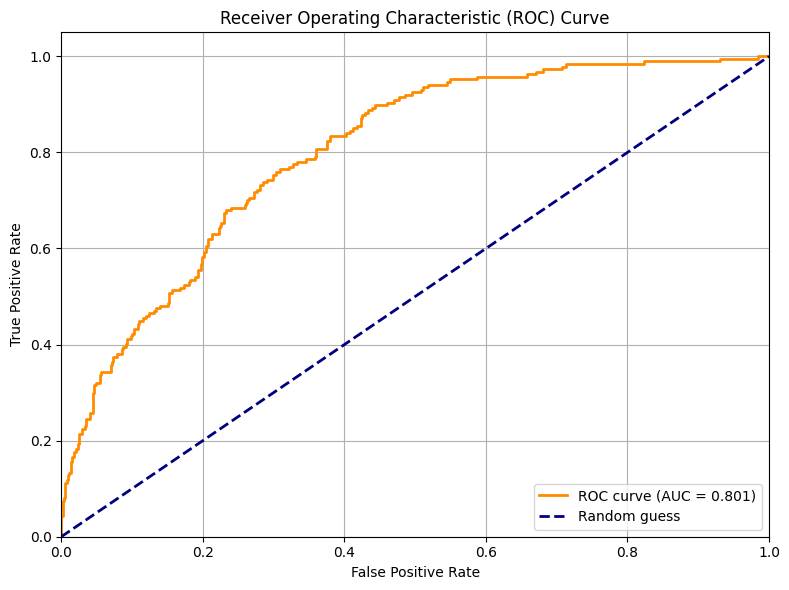

In [44]:
# Get predicted probabilities
y_proba_test = best_log_model.predict_proba(X_test)[:, 1]

# Compute False Positive Rate, True Positive Rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
<div class="alert alert-block alert-success">
<b>Reviewer's comment</b> <a class="tocSkip"></a>
Good job here trying different models and der
</div>